<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C__ch5_9~10_pg_342~375.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **09 회귀 실습 - 자전거 대여 수요 예측**

---

캐글의 자전거 대여 수요(Bike Sharing Demand) 데이터.

* 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수 기재됨.

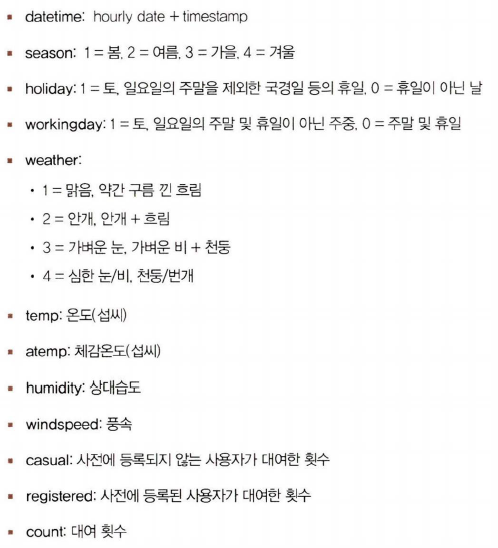

## **데이터 클렌징 및 가공**

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('/content/drive/MyDrive/bike_train.csv.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [89]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


* Null 데이터는 없으며, 대부분 int 또는 float 숫자형. datetime 칼럼만 object형.


In [90]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


* 새롭게 year, month, day, hour 칼럼 추가됨-> datetime 칼럼 삭제하기.
* casual 칼럼은 사전에 등록하지 않은 사용자의 자전거 대여 횟수, registered는 사전에 등록한 사용자의 대여 횟수. count와 상관도가 높아(합하면 count) 예측 저해할 우려가 있으므로 두 칼럼 삭제.

In [91]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

---

다양한 회귀 모델을 데이터 세트에 적용해 예측 성능 측정해보기.

RMSLE(Root Mean Square Log Error)(오류값의 로그에 대한 RMSE) 요구됨.

**RMSLE, MSE, RMSE 한번에 수행하는 성능평가 함수 생성학.**

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSE 계산
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
  rmsle_val = rmsle(y,pred)
  rmse_val = rmse(y,pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y,pred)
  print('RMSLE: {0:.3f}, RMSE:{1:.3F}, MAE: {2:.3F}'.format(rmsle_val,rmse_val, mae_val))

numpy의 log() 함수나 사이킷런의 mean_squared_log_error() 이용할 수도 있지만,

데이터 값의 크기에 따라 오버플로/언더플로 오류가 발생하기 쉬움

log1p()의 경우는 1 + log() 값으로 log 변환값에 1을 더하므로 이런 문제를 해결해줌.

## **로그 변환, 피처 인코딩과 모델 학습/예측/평가**

회귀 모델을 이용해 자전거 대여 횟수 예측해보기.
1. 회귀 모델을 적용하기 전, 결괏값이 정규 분포로 되어있는지 확인해야함
2. 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩해야함.

먼저, 사이킷런의 LinearRegression 객체를 이용해 회귀 예측을 하기.

In [93]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,
                                                    random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE:140.900, MAE: 105.924


예측 오류로서는 비교적 큰값.

실제 값과 예측값이 어느정도 차이나는지 DataFrame의 칼럼으로 만들어서 오류 값이 큰 순으로 5개만 확인해보기.

In [94]:
def get_top_error_data(y_test, pred, n_tops = 5):
  #DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성.
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

  # 예측값과 실제 값이 가장 큰 데이터 순으로 출력.
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


* 실제 값을 감안하면 예측 오류가 꽤 큼.
* 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인하는 것.

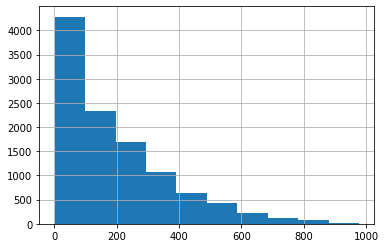

In [95]:
y_target.hist()

* count 칼럼 값이 정규 분포가 아닌 0~200 사이에 왜곡되어 있는 것을 확인 가능
* 이렇게 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환하는 것.
* log1p()를 이용하여 변경된 Target 값을 기반으로 학습하고 예측한 값은 다시 expm1() 함수를 적용해 원래 scale 값으로 원상 복구.

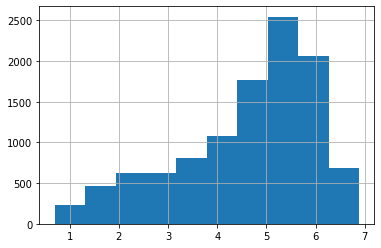

In [96]:
# log1p()를 적용한 'count' 값의 분포 확인
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

* 정규 분포 형태는 아니지만 변환 전보다 왜곡 정도 많이 향상됨.
* 이를 이용해 다시 학습한 후 평가 수행

In [97]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3,
                                                     random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE:162.594, MAE: 109.286


* RMSLE 오류는 줄었지만, RMSE는 오히려 늘어남.

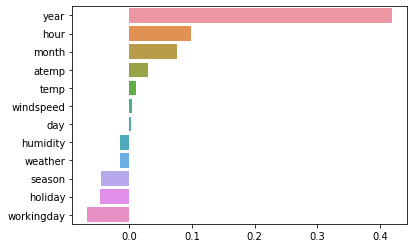

In [98]:
# 각 피처의 회귀 계수 값 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

* year 피처의 회귀 계수 값이 독보적으로 큰 값을 가지고 있음.
* year 피처가 카테고리형 피처지만 숫자형 값으로 되어있기 때문
* 사이킷런은 카테고리만을 위한 데이터 타입이 없으며 모두 숫자로 변환해야하지만, 선형 회귀에 숫자형 카테고리 값을 사용할 경우 크게 영향받을 수 있음
* 따라서 선형회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야함.

In [99]:
# 'year', 'month', 'day', 'hour' 등의 피처를 One-Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday',
                                                     'workingday', 'season', 'weather'])

사이킷런의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습해 예측 성능 확인.

이를 위해 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환하는 get_model_predict() 함수 생성.

In [100]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1 :
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__,'###')
  evaluate_regr(y_test,pred)
# end of function get_model_predict

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE:97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE:98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE:113.219, MAE: 72.803


* 원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상됨.
* 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화해보기(원-핫 인코딩으로 피처가 늘어났으므로 상위 20개 피처만 추출)

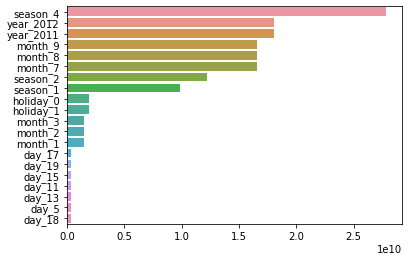

In [101]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

* 선형 회귀 모델 시 month_9, month_8, month_7 등의 월 관련 피처들과 workingday 관련 피처들, 그리고 hour 관련 피처들의 회귀 계수가 높은 것을 알 수 있음.

---

이번에는 **회귀 트리**를 이용해 회귀 예측 수행

앞에서 적용한 Target 값의 로그 변환된 값과 원-핫 인코딩된 피처 데이터 세트를 그대로 이용해 랜덤 포레스트, GBMS, XGBoost, LightGBM을 순차적으로 성능 평가해보기.
* XGBoost의 경우 DataFrAME이 학습/테스트 데이터로 입력될 경우 버전에 따라 오류가 발생할 수 있으므로 학습/테스트 데이터를 DataFrame의 values 속성을 이용해 넘파이 ndarray로 변환.

In [102]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
  # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE:50.451, MAE: 31.245
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE:53.343, MAE: 32.745
[05:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.345, RMSE:58.245, MAE: 35.768
### LGBMRegressor ###
RMSLE: 0.319, RMSE:47.215, MAE: 29.029


앞의 선형 회귀 모델보다 회귀 예측 성능이 개선됐지만, 이것이 회귀 트리가 선형 회귀보다 더 나은 성능을 가진다는 의미는 아님.

# **10 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법**

---

* 79개의 변수로 구성됨
* 미국 아이오와 주의 에임스(Ames) 지방의 주택 가격 정보를 가지고 있음.
* 성능평가는 RMSLE(Root Mean Squared Log Error)를 기반으로 함.
* 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 바중이 높으므로 이것을 상쇄하기 위해 오류 값을 로그 변환한 RMSLE를 이용.

## **데이터 사전 처리(Preprocessing)**

In [103]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/drive/MyDrive/house_price.csv.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Target 값은 맨 마지막 칼럼인 SalePrice.

In [104]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series >0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


* 숫자형 뿐 아니라 문자형도 많이 있음.
* Target을 제외한 80개의 피처 중 43개가 문자형.
* 데이터 양에 비해 Null 값이 많은 피처도 있음.
* PoolQC, MiscFeature, Alley, Fence는 1480개의 데이터 중 1000개가 넘는 데이터가 Null->드롭

---

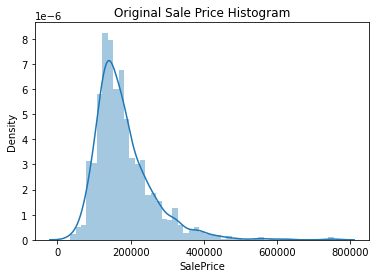

In [105]:
# 회귀 모델 적용 전, 타깃 값의 분포도가 정규 분포인지 확인
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

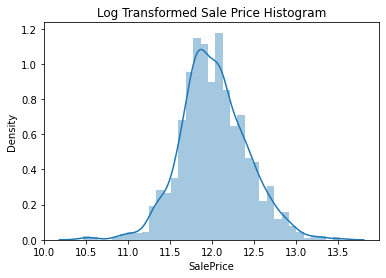

In [106]:
#정규분포가 아닌 결괏값을 정규 분포 형태로 변환하기 위해 로그변환(Log Transformation) 적용.
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

정규분포 형태로 결괏값이 분포함. 이제 SalePrice를 로그 변환한 뒤 DataFrame에 반영.

In [107]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

#Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

#드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


* 이제 문자형 피처를 제외하고는 Null 값이 없음
* 문자형 피처는 모두 get_dummies()로 원-핫 인코딩으로 변환
* get_dummies()는 자동으로 문자열 피처를 원-핫 인코딩 변환하면서 Null 값은 'None'칼럼으로 대체해주기 때문에 별도의 Null 값 대체 로직 필요 없음.

In [108]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


## **선형 회귀 모델 학습/예측/평가**

예측 평가를 RMSLE를 이용할건데 이미 타깃 값인 SalePrice가 로그 변환됨.

예측값 역시 로그 변환된 SalePrice 값을 기반으로 예측하므로 원본 SalePrice 예측값의 로그 변환값임.

->예측결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정됨.

In [109]:
# 여러 모델의 로그 변환된 rmse를 측정할 것이므로 이를 계산하는 함수 먼저 생성
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse,3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [110]:
# 이제 선형 회귀 모델 학습, 예측 평가
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                    random_state=156)

#LinearRegression, Ridge, Lasso 학습, 예측 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154202, 0.12750846334052995, 0.17628250556471403]

* 라쏘 회귀의 경우 회귀 성능이 타 회귀 방식보다 많이 떨어지는 결과가 나옴-> 최적 하이퍼 파라미터 튜닝이 필요해보임.
* 그보다 먼저 피처별 회귀 계수를 시각화해서 모델별로 어떠한 피처의 회귀 계수로 구성되는지 확인해보기.

In [111]:
def get_top_bottom_coef(model, n=10):
  #coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
  coef = pd.Series(model.coef_, index=X_features.columns)

  # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환.
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

생성한 get_top_bottoms(model, n=10) 함수를 이용해 모델별 회귀 계수 시각화.

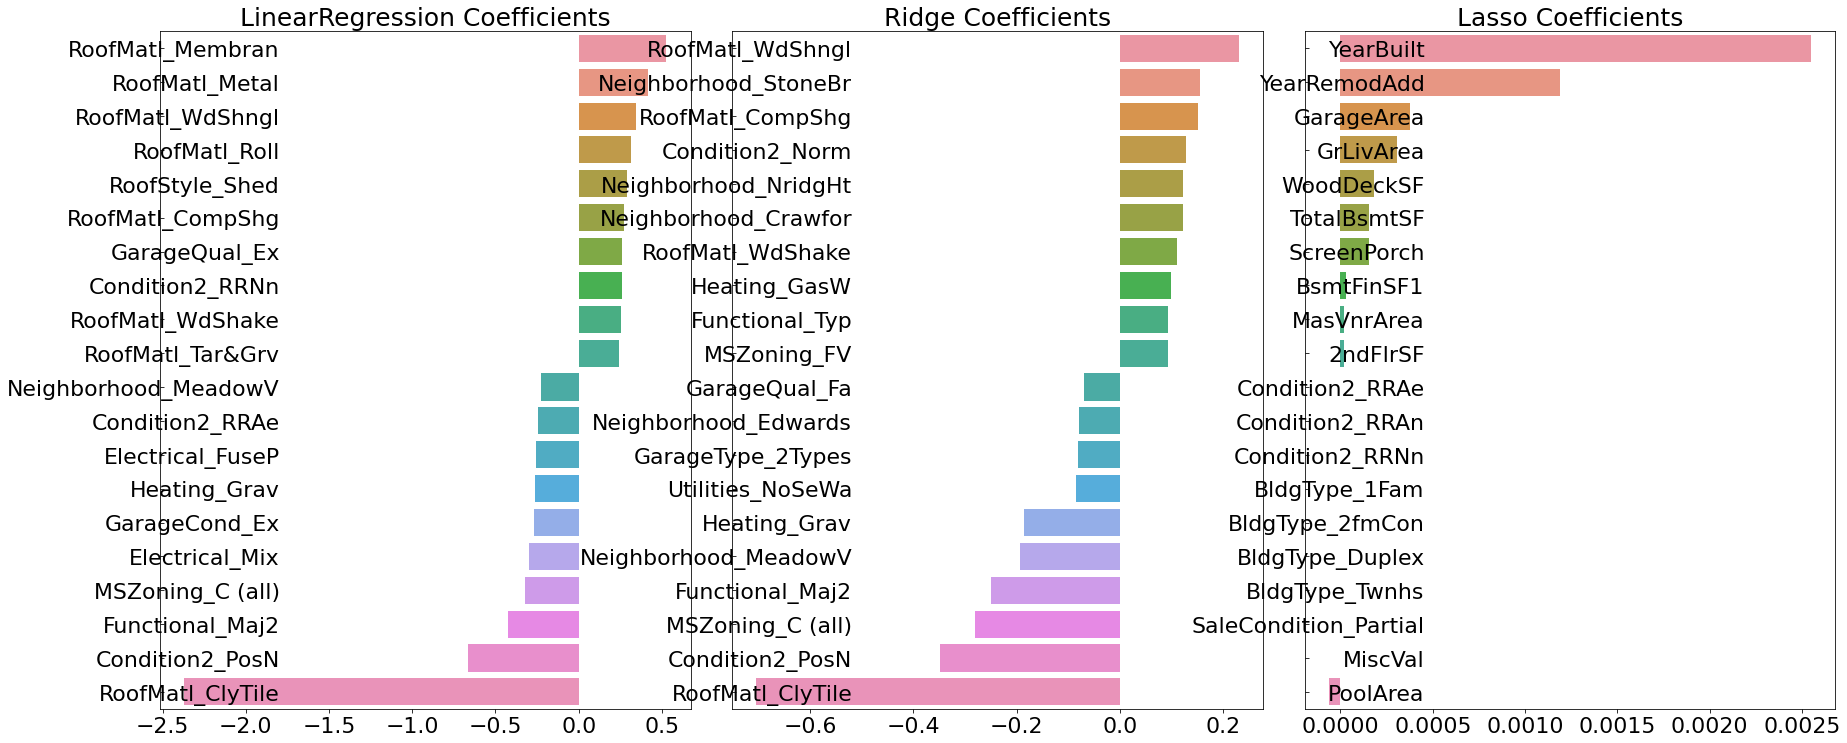

In [112]:
def visualize_coefficient(models):
  # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
  fig.tight_layout()
  # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
  for i_num, model in enumerate(models):
    # 상위 10개, 하위 10개 회귀 계수를 구하고 이를 판다스 concat으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])
    # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
    axs[i_num].set_title(model.__class__.__name__+' Coefficients', size=25)
    axs[i_num].tick_params(axis="y",direction="in", pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

모델별 회귀 계수를 보면 OLS기반의 LinearRegression과 Ridge의 경우는 회귀 계수가 유사한 형태로 분포돼있음.

그러나 라쏘(Lasso)는 전체적으로 휘귀 계수 값이 매우 작고, YearBuilt가 가장 크고 다른 피처의 회귀 계수는 너무 작음.

학습 데이터의 데이터 분할에 문제가 있어서 그런 것인지, 학습과 테스트 데이터 세트를 train_test_split()으로 분할하지 않고 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE를 측정해보기.(cross_val_score())

In [113]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

  for model in models:
    # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                         scoring="neg_mean_squared_error", cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models ={lr_reg, ridge_reg, lasso_reg}
get_avg_rmse_cv(models)


Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


* 5개의 폴드 세트로 학습한 후 평가해도 여전히 라쏘의 경우가 OLS 모델이나 렛지 모델보다 성능이 떨어짐.
* 릿지와 라쏘 모델에 대해 alpha 하이퍼 파라미터를 변화시키며 최적 값 도출.

In [114]:
# 모델 별로 최적화 하이퍼 파라미터 작업을 반복적으로 진행하므로 이를 위한 별도의 함수 생성
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                           np.round(rmse,4), grid_model.best_params_))

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


릿지 모델의 경우 최적화 이후 alpha 값 예측 성능이 많이 좋아짐.

선형 모델에 최적 alpha값을 설정한 뒤, train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 학습/예측/평가 수행 후 모델별 회귀 계수 시각화.

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


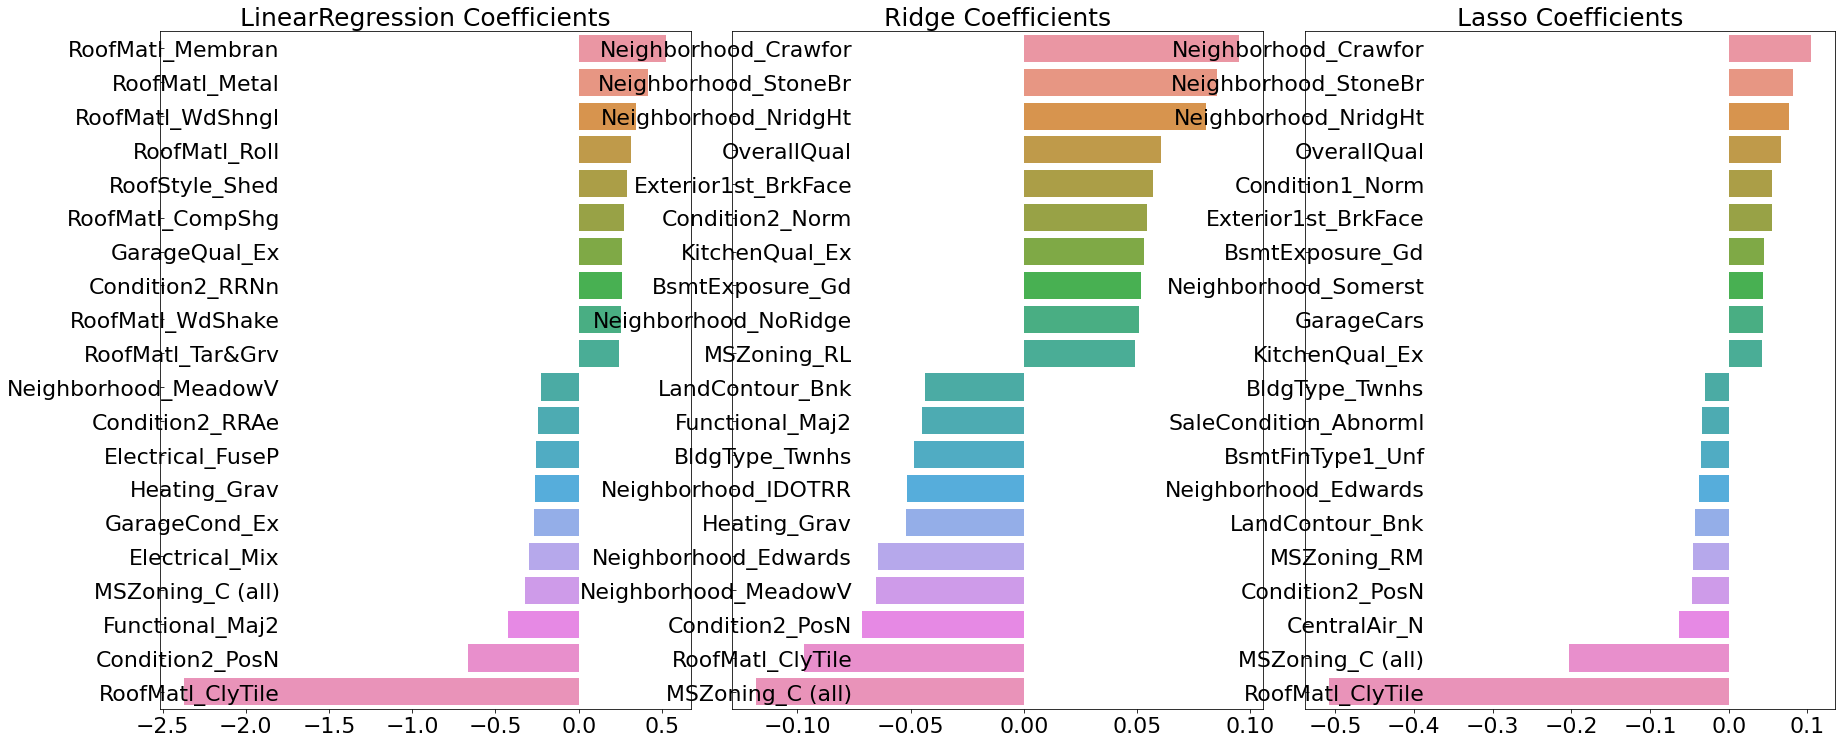

In [115]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

alpha 값 최적화 후 테스트 데이터 세트의 예측 성능은 더 좋아짐.
* 모델별 회귀 계수 많이 달라짐
* 다만, 라쏘 모델의 경우 릿지에 비해 동일한  피처라도 회귀 계수의 값이 상당히 작음

---

데이터 세트를 추가적으로 가공해서 모델 튜닝 진행.

1. 피처 데이터 세트의 데이터 분포도
2. 이상치(Outlier) 데이터 처리

예제 초반에 타깃 데이터 세트의 데이터 분포도의 왜곡 확인함.

피처 데이터 세트의 경우도 지나치게 왜곡된 피처가 존재할 경우 회귀 예측 성능을 저하시킬 수 있음.

사이파이 stats 모듈의 skew() 함수를 이용해 칼럼의 데이터 세트의 왜곡된 정도 추출.
* 일반적으로 skew() 함수의 반환 값이 1 이상인 경우를 왜곡 정도가 높다고 판단하지만, 상황에 따라 편차는 있음.
* 여기서는 1 이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위해 로그 변환 적용.
* skew()를 적용하는 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처는 제외해야함.(카테고리 피처는 왜곡될 가능성이 높음)

In [121]:
from scipy.stats import skew

#object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes!= 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트를 반환. aplly lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
#skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64


In [122]:
# 추출된 왜곡 정도가 높은 피처를 로그 변환.
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

로그 변환 후 왜곡 정도를 다시 확인해보면 여전히 높은 왜곡 정도를 가진 피처도 있지만, 더이상 로그 변환을 하더라도 개선하기는 어려움.

---

house_df의 피처를 일부 로그 변환했으므로 다시 원-핫 인코딩을 적용한 house_df_ohe 만들기.

In [124]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                    random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_parmas = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1276, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1251, 최적 alpha:{'alpha': 0.001}


* 릿지 모델의 경우 최적 alpha 값이 12에서 10으로 변경됨.
* 두 모델 모두 피처의 로그 변환 이전과 비교해 5폴드 교차 검증의 평균 RMSE 값 향상됨.

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.121
Lasso 로그 변환된 RMSE: 0.117


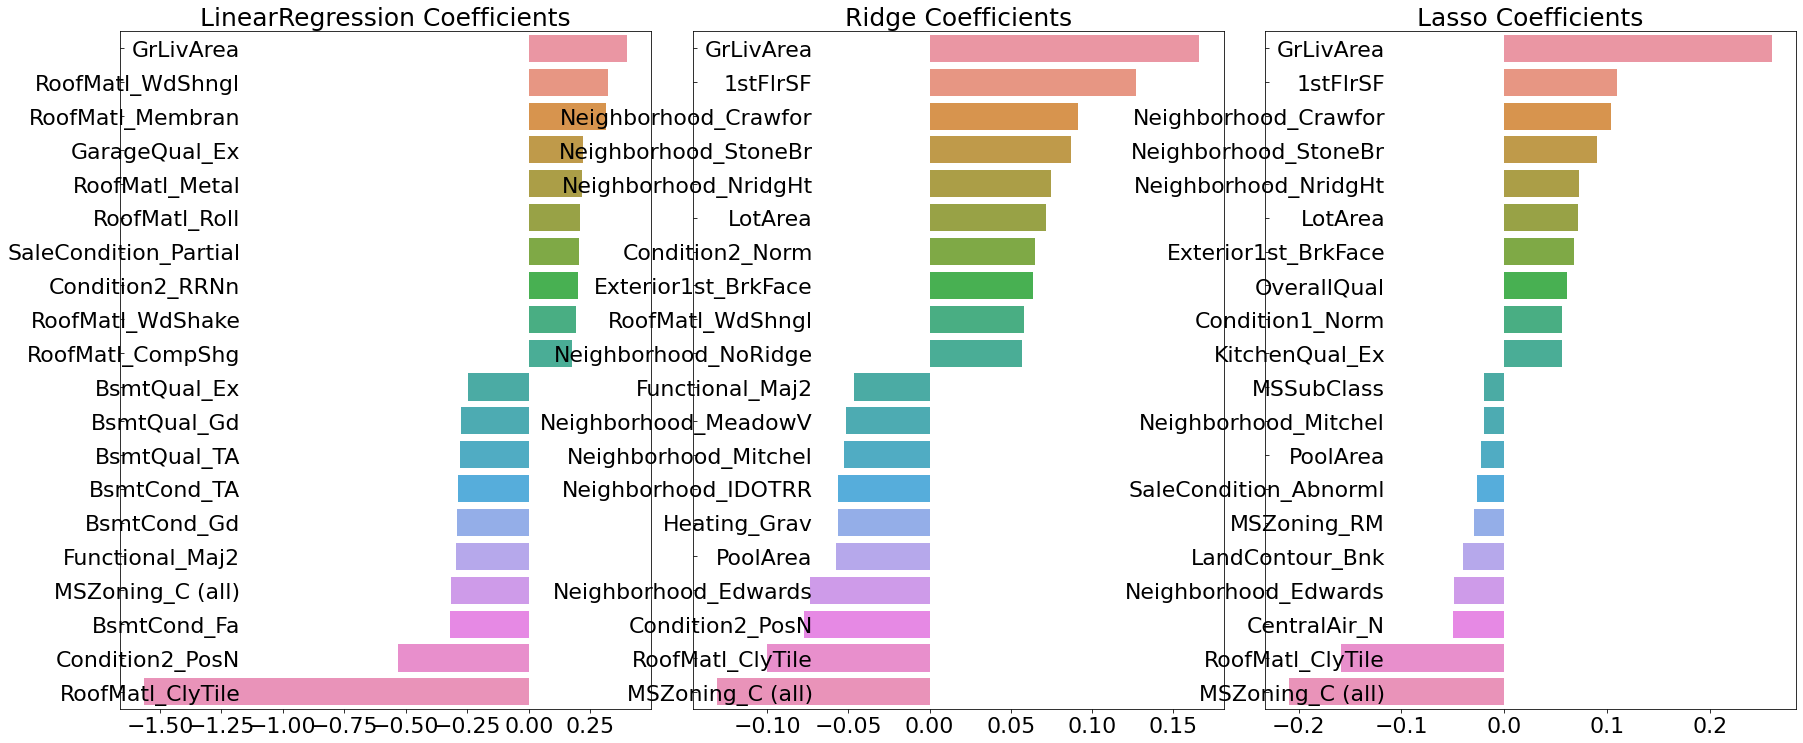

In [125]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

---

**이상치 데이터**

* 회귀 계수가 높은 피처, 즉 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터의 처리가 중요함.

먼저 세 개 모델 모두에서 가장 큰 회귀 계수를 가지는 GrLiveArea 피처의 데이터 분포 살피기.

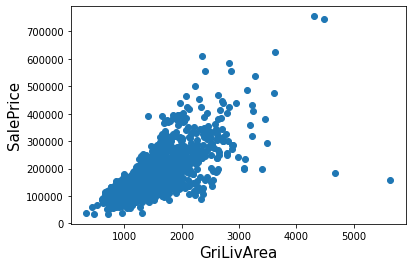

In [128]:
# 주택 가격 데이터가 변환되기 이전의 원본 데이터 세트인 house_df_org에서
# GrLivArea와 타깃 값인 SalePrice의 관계 시각화.
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GriLivArea', fontsize=15)
plt.show()

일반적으로 주거 공간이 큰 집일수록 가격이 비싸기 때문에 GrLivArea 피처는 SalePrice와 양의 상관도가 매우 높음을 직관적으로 알 수 있음

그러나 위 그래프에서 오른쪽 아래의 2개의 데이터는 일반적인 둘 사이의 관계에서 너무 어긋나있음.(이상치)

In [130]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제.
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 271)
이상치 삭제 후 house_df_ohe shape: (1458, 271)


In [132]:
# 업데이트 된 house_df_ohe를 기반으로 피처 데이터 세트와 타깃 데이터 세트를 다시 생성.
# 앞에서 정의한 print_best_params() 함수를 이용해 릿지와 라쏘 모델의 최적화 수행 후 결과 출력
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                    random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_parmas = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_parmas)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


* 단 두개의 이상치 데이터만 제거했는데 예측 수치 매우 크게 향상됨.
* GrLivArea 속성이 회귀 모델에서 차지하는 영향도가 크기에 이 이상치를 개선하는 것이 성능 개선에 큰 의미를 가짐.

---

회귀에 중요한 영향을 미치는 피처를 위주로 이상치 데이터를 찾으려는 노력은 중요함.
* 보통 머신러닝 프로세스 중에서 데이터의 가공은 알고리즘을 적용하기 이전에 수행.
* 하지만 이것이 머신러닝 알고리즘을 적용하기 이전에 완벽하게 데이터의 선처리 작업을 수행하라는 의미는 아님.
* 일단 대략의 데이터 가공과 모델 최적화를 수행한 뒤 다시 이에 기반한 여러가지 기법의 데이터 가공과 하이퍼 파라미터 기반의 모델 최적화를 반복적으로 소행하는 것이 바람직한 머신러닝 모델 생성 과정

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


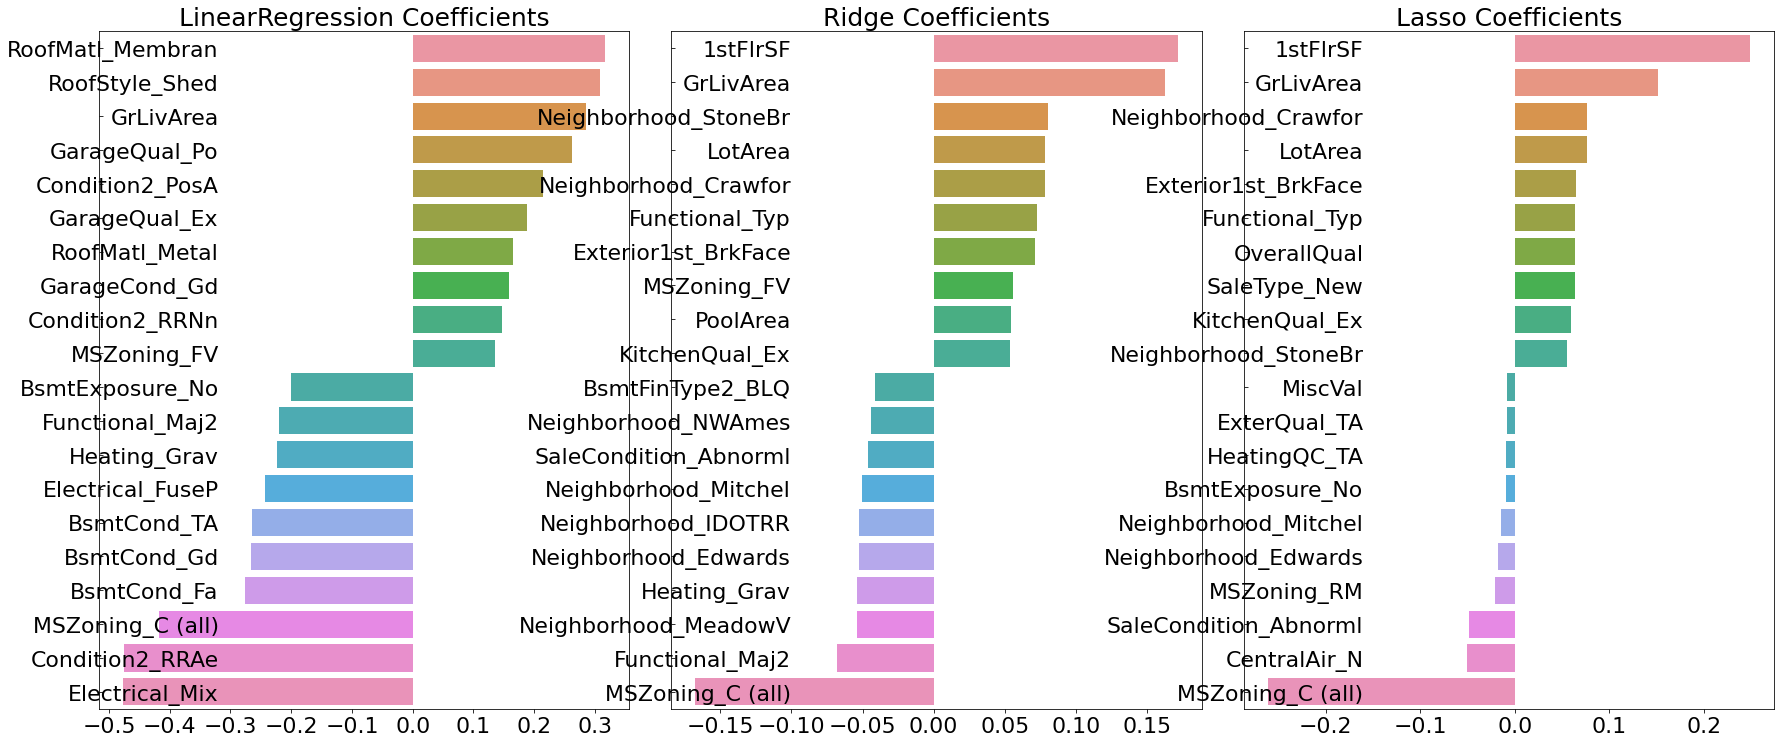

In [133]:
# 이상치가 제거된 데이터 세트를 기반으로 다시
# train_test_split()으로 분할된 데이터 세트의 RMSE 수치 및 회귀 계수 시각화한 결과.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

## **회귀 트리 모델 학습/예측/평가**

---

* 이번에는 회귀 트리를 이용해 회귀 모델 생성
* XGBoost는 XGBRegressor 클래스를, LightGBM은 LGBMRegressor 클래스를 이용.
* 둘 다 수행 시간이 오래 걸릴 수 있으므로 다음과 같이 하이퍼 파라미터 설정을 미리 적용한 상태로 5폴드 세트에 대한 평균 RMSE 값 구하기.

In [135]:
# XGBoost 회귀 트리 적용
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

[06:12:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1151, 최적 alpha:{'n_estimators': 1000}


XGBoost 회귀 트리 적용 시 5 폴드 세트 평균 RMSE=0.1151

In [138]:
#LightGBM 회귀 트리 적용
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값:0.1161, 최적 alpha:{'n_estimators': 1000}


## **회귀 모델의 예측 결과 혼합을 통한 최종 예측**

---

이번에는 개별 회귀 모델의 예측 결괏값을 혼합해 이를 기반으로 최종 회귀 값 예측.

예측 결과 혼합: A 모델 예측값의 40%, B 모델 예측값의 60%를 더해서 최종 회귀 값으로 예측.

In [139]:
# 릿지 모델과 라쏘 모델 혼합
#최종 혼합 모델, 개별 모델의 RMSE 값을 출력하는 get_rmse_pred() 함수 생성
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE: {1}'.format(key,rmse))
  
# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
#개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.09970842737250565
Ridge 모델의 RMSE: 0.10313299412082633
Lasso 모델의 RMSE: 0.09991843167945541


최종 혼합 모델의 RMSE가 개별 모델보다 성능 면에서 약간 개선됨.

---

이번에는 XGBoost와 LightGBM 혼합.

In [140]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)

[06:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE: 0.09897715854093486
XGBM 모델의 RMSE: 0.10075115846547565
LGBM 모델의 RMSE: 0.1015065721553885


## **스태킹 앙상블 모델을 통한 회귀 예측**

---

4장 분류에서 소개한 스태킹 모델을 회귀에도 적용 가능.
* 스태킹 모델은 두 종류의 모델 필요
1. 개별적인 기반 모델
2. 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델
* 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것.
* 최종 메타 모델이 학습할 피처 데이터 세트는 원본 학습 피처 세트로 학습한 개별 모델의 예측값을 스태킹 형태로 결합한 것.

In [144]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정된 n_folds 값으로 KFold 생성
  kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:, folder_counter] = model.predict(X_test_n)
  
  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

릿지, 라쏘, XGBoost, LightGBM 모델 적용.

In [145]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train. values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
Lasso model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
XGBRegressor model 시작
	 폴드 세트:  0 시작
[06:52:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1 시작
[06:52:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2 시작
[06:52:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3 시작
[06:52:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4 시작
[06:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 

각 개별 모델에 반환하는 학습용 피처 데이터와 테스트용 피처 데이터 세트를 결합해 최종 메타 모델에 적용하기.

메타 모델은 별도의 라쏘 모델을 이용하며 최종적으로 예측 및 RMSE를 측정.

In [148]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09828160415054343


최종적으로 스태킹 회귀 모델을 적용한 결과, 테스트 데이터 세트에서 RMSE가 약 0.0983으로 현재까지 가장 좋은 성능 평가를 보여줌.